In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
project_name='05b-cifar10-resnet'

In [2]:
# Download the dataset
datasetUrl = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(datasetUrl, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
dataDir = './data/cifar10'

Using downloaded and verified file: ./cifar10.tgz


In [3]:
# Data transforms (normalization & data augmentation)
# First will pad images with 4 pixels and random horizontal flip so that there is a different image every epoch which
# allows the model to generalize better
# Will normalize the image tensors by subtracting the mean and dividing accross the standard deviation accross 
# each channel, preventing any one channel from disproportionally  affecting losses and gradients by having 
# by having a wider and larger range of values

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # mean and standardard deviation for the 3 channels
trainTfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace = True)])
validTfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [4]:
# PyTorch datasets
trainDs = ImageFolder(dataDir+'/train', trainTfms)
validDs = ImageFolder(dataDir+'/test', validTfms)

batchSize = 100

In [5]:
# PyTorch data loaders
trainDl = DataLoader(trainDs, batchSize, shuffle = True, num_workers = 3, pin_memory = True)
validDl = DataLoader(validDs, batchSize*2, num_workers = 3, pin_memory = True)

In [6]:
# Calculating the accuracy of the validation set
def accuracy(outputs, labels):
    """
    Returns a percentage that is the accuracy of the images predicted correctly on the validation set.
    
    Parameters
    ----------
    ouputs : predictions of the images
    labels : actual labels of the images
    
    """
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    """
    Generates predictions, loss, and accuracy of the model during training and validation.
    
    Attributes
    ----------
    N/A
    
    Methods
    -------
    training_step(self, batch)
        Generates predictions and loss of the images in the batch of training dataset.
    validation_step(self, batch)
        Generates predictions, loss, and accuracy of the images in the batch of validation dataset.
        validation dataset.
    validation_epoch_end(self, outputs)
        Returns the loss and accuracy of each epoch.
    epoch_end(self, epoch, result)
        Prints results of each epoch.

    """
    
    def training_step(self, batch):
        """
        Generates predictions of the images in the batch and returns the loss of the training dataset.

        Parameters
        ----------
        batch : A batch of images.
        
        """
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        """
        Generates predictions of the images in the batch and returns the loss and accuracy of the validation dataset.

        Parameters
        ----------
        batch : A batch of images.
        
        """
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'valLoss': loss.detach(), 'valAcc': acc}
        
    def validation_epoch_end(self, outputs):
        """
        Returns the loss and accuracy of each epoch.

        Parameters
        ----------
        outputs : Predictions of the images.
        
        """
        batchLosses = [x['valLoss'] for x in outputs]
        epochLoss = torch.stack(batchLosses).mean()   # Combine losses
        batchAccs = [x['valAcc'] for x in outputs]
        epochAcc = torch.stack(batchAccs).mean()      # Combine accuracies
        return {'valLoss': epochLoss.item(), 'valAcc': epochAcc.item()}
    
    def epoch_end(self, epoch, result):
        """
        Prints the epoch, learning rate, training loss, validation loss, and validation accuracy.

        Parameters
        ----------
        epoch : Current epoch.
        result: Results from current epoch.
        
        """
        print("Epoch [{}], lastLr: {:.5f}, trainLoss: {:.4f}, valLoss: {:.4f}, valAcc: {:.4f}".format(
            epoch, result['lrs'][-1], result['trainLoss'], result['valLoss'], result['valAcc']))

In [7]:
# Use this multiple times and increase no. of channels to improve accuracy
def conv_block(inChannels, outChannels, pool = False):
    """
    Convolutional block that performs a convolution, normalization, and activation function.
    This is used multiple times to increase no. of channels and improve accuracy.
    Parameters
    ----------
    inChannels : Current number of channels.
    outChannels: Number of channels after convolution.
    pool: Whether a 2x2 max pool should be applied.

    Returns
    -------
    Returns the layers combined sequentially.
    """
    layers = [nn.Conv2d(inChannels, outChannels, kernel_size = 3, padding = 1), 
              nn.BatchNorm2d(outChannels), 
              nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    """
    Performs the ResNet9 architecture.
    
    Attributes
    ----------
    conv1 : Applies the conv_block from 32 channels to 62 channels.
    conv2 : Applies the conv_block from 64 channels to 128 channels.
    res1: Puts the convolution of 128 channels into a sequential container.
    conv3 : Applies the conv_block from 128 channels to 256 channels.
    conv4 : Applies the conv_block from 256 channels to 512 channels.
    res2: Puts the convolution of 512 channels into a sequential container.
    
    Methods
    -------
    __init__(self, inChannels, numClasses)
        Creates conv1, conv2, res1, conv3, conv4, res2.
    forward(self, xb)
        Creating the residual blocks of ResNet9 architecture.
    """
    def __init__(self, inChannels, numClasses):
        super().__init__()
        
        self.conv1 = conv_block(inChannels, 64)
        self.conv2 = conv_block(64, 128, pool = True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool = True)
        self.conv4 = conv_block(256, 512, pool = True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, numClasses)) # from 512 channels to 10 probability outputs
        
    # Using residual blocks so adding the output with the inital input
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [8]:
# From 3 channels to 10 outputs (1 for each class)
model = ResNet9(3, 10)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [9]:
@torch.no_grad()
def evaluate(model, valLoader):
    """
    Evaluating the validation set
    
    Parameters
    ----------
    model : Model defined.
    valLoader : Validation data loader.

    Returns
    -------
    Returns predictions of the images.
    """
    model.eval()
    outputs = [model.validation_step(batch) for batch in valLoader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    """
    Gets the Learning Rate Scheduler which will change learning rate after every batch of training.
    Start with low learning rate, gradually increase it, and then decrease it again
    
    Parameters
    optimizer : The chosen optimizer.

    Returns
    -------
    Returns the learning rate.
    """
    for paramGroup in optimizer.param_groups:
        return paramGroup['lr']

def fit_one_cycle(epochs, maxLr, model, trainLoader, valLoader, 
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    """
    Initializes optimizer, performs training loop, performs validation.
    
    Parameters
    epochs : Number of epochs.
    maxLr : Maximum learning rate.
    model : The model.
    trainLoader : Training data loader.
    valLoader : Validation data loader.
    weight_decay : Weight decay (prevents weight from being to large), default is 0.
    grad_clip : Gradient clipping (limits gradient to small range), default is None.
    opt_func : Optimization function, default is torch.optim.SGD

    Returns
    -------
    Returns a list with the validation loss and validation accuracy.
    """
    history = []
    
    # Set up cutom optimizer with weight decay (prevents weight from being too large)
    optimizer = opt_func(model.parameters(), maxLr, weight_decay = weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, maxLr, epochs = epochs, 
                                                steps_per_epoch = len(trainLoader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        trainLosses = []
        lrs = []
        for batch in trainLoader:
            loss = model.training_step(batch)
            trainLosses.append(loss)
            loss.backward()
            
            # Gradient clipping (limit gradient to small range)
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, valLoader)
        result['trainLoss'] = torch.stack(trainLosses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
history = [evaluate(model, validDl)]
history

[{'valLoss': 2.3043172359466553, 'valAcc': 0.11480000615119934}]

In [11]:
epochs = 8
maxLr = 0.01
gradClip = 0.1
weightDecay = 1e-4
optFunc = torch.optim.Adam

In [12]:
%%time
history += fit_one_cycle(epochs, maxLr, model, trainDl, validDl, 
                             grad_clip = gradClip, 
                             weight_decay = weightDecay, 
                             opt_func = optFunc)

Epoch [0], lastLr: 0.00395, trainLoss: 1.4307, valLoss: 1.6249, valAcc: 0.4940
Epoch [1], lastLr: 0.00936, trainLoss: 1.0810, valLoss: 0.8512, valAcc: 0.6911
Epoch [2], lastLr: 0.00972, trainLoss: 0.7808, valLoss: 0.8354, valAcc: 0.7133
Epoch [3], lastLr: 0.00812, trainLoss: 0.6808, valLoss: 0.7707, valAcc: 0.7364
Epoch [4], lastLr: 0.00556, trainLoss: 0.6023, valLoss: 0.5568, valAcc: 0.8092
Epoch [5], lastLr: 0.00283, trainLoss: 0.4983, valLoss: 0.4592, valAcc: 0.8452
Epoch [6], lastLr: 0.00077, trainLoss: 0.3735, valLoss: 0.3248, valAcc: 0.8889
Epoch [7], lastLr: 0.00000, trainLoss: 0.2581, valLoss: 0.2863, valAcc: 0.9047
CPU times: user 3h 12min 59s, sys: 24min 29s, total: 3h 37min 28s
Wall time: 1h 33min 23s


In [13]:
def plot_accuracies(history):
    accuracies = [x['valAcc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

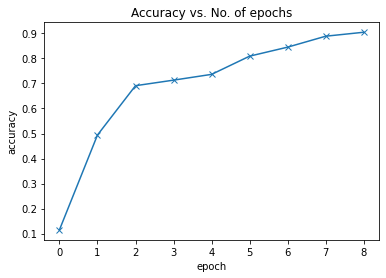

In [14]:
plot_accuracies(history)

In [15]:
def plot_losses(history):
    train_losses = [x.get('trainLoss') for x in history]
    val_losses = [x['valLoss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

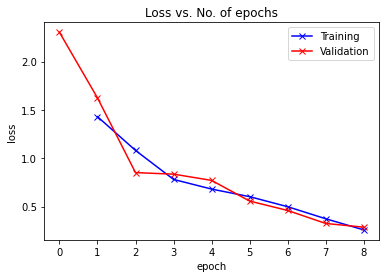

In [16]:
plot_losses(history)